In [0]:
import tensorflow as tf
import numpy as np
import tensorflow.python.keras as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation,Dense,Conv2D,Conv2DTranspose,LeakyReLU,Flatten,Dropout,BatchNormalization, Reshape,UpSampling2D
import matplotlib.pyplot as plt
import gc

In [0]:
class DCGAN(object):
  def __init__(self):
    self.img_rows=28
    self.img_cols=28
    self.img_chn=1

    (self.x_train,self.y_train), (self.x_test,self.y_test) = tf.python.keras.datasets.mnist.load_data()

    self.x_train=(self.x_train -127.5)/127.5  
    self.x_train=self.x_train.reshape(-1,28,28,1).astype("float32")

    self.D = None   # discriminator
    self.G = None   # generator
    self.AM = None  # adversarial model
    self.DM = None  # discriminator model

    self.generator_network = self.generator()
    self.discriminator_network =  self.discriminator_model()
    self.adversarial_network = self.adversarial_model()

  def generator(self):
    if self.G:
      return self.G

    self.G = Sequential()
    self.G.add(Dense(7*7*256,input_dim=100))
    self.G.add(BatchNormalization(momentum=0.9))
    #G.add(Activation("relu"))
    self.G.add(LeakyReLU())
    self.G.add(Reshape((7,7,256)))
    self.G.add(Dropout(0.4))

    self.G.add(UpSampling2D())
    self.G.add(Conv2DTranspose(128,5,padding="same"))
    self.G.add(BatchNormalization(momentum=0.9))
    #G.add(Activation("relu"))
    self.G.add(LeakyReLU())

    self.G.add(UpSampling2D())
    self.G.add(Conv2DTranspose(64,5,padding="same"))
    self.G.add(BatchNormalization(momentum=0.9))
    #G.add(Activation("relu")) 
    self.G.add(LeakyReLU())

    self.G.add(Conv2DTranspose(32,5,padding="same"))
    self.G.add(BatchNormalization(momentum=0.9))
    self.G.add(Activation("relu"))

    self.G.add(Conv2DTranspose(1,5,padding="same",activation="tanh"))
    return self.G  

  def discriminator(self):
    if self.D:
      return self.D

    input_shape = (self.img_rows,self.img_cols,self.img_chn)
    self.D = Sequential()
    self.D.add(Conv2D(64,5,strides=2,padding="same",input_shape=input_shape))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(0.4))

    self.D.add(Conv2D(128,5,strides=2,padding="same"))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(0.4))

    self.D.add(Conv2D(256,5,strides=2,padding="same"))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(0.4))

    self.D.add(Conv2D(512,5,padding="same"))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(0.4))

    self.D.add(Flatten())
    self.D.add(Dense(1,activation="sigmoid"))

    return self.D  
  
  def discriminator_model(self):
    if self.DM:
      return self.DM
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    #discriminator(img_rows,img_cols,img_chn).trainable = True
    self.DM = Sequential()
    self.DM.add(self.discriminator())
    self.DM.compile(loss="binary_crossentropy",optimizer=optimizer)
    return self.DM

  def adversarial_model(self):
    if self.AM:
      return self.AM

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5) 
    self.AM = Sequential()
    self.AM.add(self.generator())
    #discriminator(img_rows,img_cols,img_chn).trainable = False
    self.discriminator().trainable = False
    self.AM.add(self.discriminator())
    self.AM.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return self.AM

  def training(self,epochs=200):
    for i in range(epochs):
      img_train=self.x_train[np.random.randint(0,self.x_train.shape[0],size=256),:,:,:]
      noise=np.random.normal(size=[256,100])
      fake_img=self.generator_network.predict(noise)
      #if i%50==0:
      #  G.save_weights(folder_path+"g_model_"+str(i)+".h5")

      x=np.concatenate((img_train,fake_img))
      y=np.ones([2*256,1])
      y[256:,:]=0
      
      self.discriminator().trainable = True
      dloss=self.discriminator_network.train_on_batch(x,y)
      #if i%50==0:
      #  DM.save_weights(folder_path+"d_model_"+str(i)+".h5")

      noise=np.random.normal(size=[256,100])
      y=np.ones([256,1])
      #discriminator_model(x_train.shape[1],x_train.shape[2],x_train.shape[3]).trainable = False
      self.discriminator().trainable = False
      aloss=self.adversarial_network.train_on_batch(noise,y)
      #if i%50==0:
      #  AM.save_weights(folder_path+"a_model_"+str(i)+".h5")

      print_msg = "iter#%d : (D Loss: %f)" % (i,dloss)
      print_msg = "%s (A Loss: %f, A Acc: %f)" % (print_msg,aloss[0],aloss[1])
      print(print_msg)
  
  def plot_images(self):
    noise = np.random.normal(size=[16, 100])
    images=self.generator_network.predict(noise)

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = (images[i, :, :, :]*127.5) + 127.5
        image = np.reshape(image, [self.img_rows, self.img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

In [0]:
dcgan=DCGAN()
gc.collect()

11493376/11490434 [==============================] - 0s 0us/step


30

In [0]:
dcgan.training(epochs=10000)

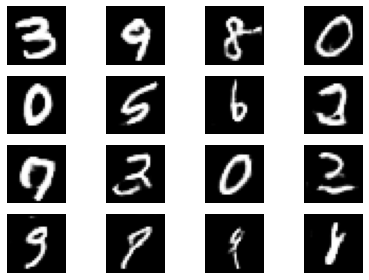

In [0]:
dcgan.plot_images()